# Multi-Head YOLO Training Notebook
## Ball Detection + Classification

This notebook implements a custom multi-head YOLO model that:
1. **Detects** balls in images (bounding boxes)
2. **Classifies** detected balls into basketball, football, or tennis-ball

**Architecture**: YOLOv5n + Custom Classification Head

---

## 📦 Part 1: Setup and Installation

In [ ]:
# Install required packages
!pip install torch torchvision
!pip install opencv-python
!pip install matplotlib
!pip install pyyaml
!pip install tqdm
!pip install seaborn
!pip install tensorboard

In [ ]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17817, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17817 (delta 12), reused 6 (delta 6), pack-reused 17795 (from 3)
Receiving objects: 100% (17817/17817), 16.99 MiB | 18.41 MiB/s, done.
Resolving deltas: 100% (12145/12145), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.5.0
    Uninstalling urllib3-2.5.0:
      Successfully uninstalled urllib3-2.5.0


In [ ]:
# Import libraries
import torch
import torch.nn as nn
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import os
import shutil

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

🖥️  Using device: cuda
   GPU: Tesla T4
   Memory: 15.64 GB


## 📁 Part 2: Dataset Preparation

In [ ]:
# specifying path to the dataset|
dataset_zip = "/content/ball_multiclass_dataset.zip"

In [ ]:
# Extract dataset
import zipfile

# Extract
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('.')

# Verify extraction
dataset_path = Path('merged_ball_dataset')
print(f"\n📊 Dataset structure:")
!ls -lh merged_ball_dataset/

# Count files
num_images = len(list((dataset_path / 'images').glob('*')))
num_labels = len(list((dataset_path / 'labels').glob('*')))
print(f"\n✅ Found {num_images} images and {num_labels} labels")


📊 Dataset structure:
total 28K
-rw-r--r-- 1 root root  77 Feb 12 13:18 data.yaml
drwxr-xr-x 2 root root 12K Feb 12 13:18 images
drwxr-xr-x 2 root root 12K Feb 12 13:18 labels

✅ Found 210 images and 210 labels


In [ ]:
# Create train/val split
import random

# Get all images
all_images = list((dataset_path / 'images').glob('*'))
random.shuffle(all_images)

# Split: 70% train, 30% val
split_idx = int(len(all_images) * 0.7)
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

print(f"\n📊 Dataset Split:")
print(f"   Training: {len(train_images)} images")
print(f"   Validation: {len(val_images)} images")

# Create train/val directories
train_dir = dataset_path / 'train'
val_dir = dataset_path / 'val'

for split_dir in [train_dir, val_dir]:
    (split_dir / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'labels').mkdir(parents=True, exist_ok=True)

# Copy files to train/val
def copy_to_split(image_list, split_dir):
    for img_path in image_list:
        # Copy image
        shutil.copy(img_path, split_dir / 'images' / img_path.name)

        # Copy corresponding label
        label_path = dataset_path / 'labels' / (img_path.stem + '.txt')
        if label_path.exists():
            shutil.copy(label_path, split_dir / 'labels' / label_path.name)

copy_to_split(train_images, train_dir)
copy_to_split(val_images, val_dir)

print("\n✅ Train/val split complete!")


📊 Dataset Split:
   Training: 147 images
   Validation: 63 images

✅ Train/val split complete!


In [ ]:
# Update data.yaml for YOLOv5
data_yaml_content = f"""
# Ball Detection Dataset Configuration

# Paths (relative to this file)
path: {dataset_path.absolute()}
train: train/images
val: val/images

# Classes
nc: 1  # For detection: single class "ball"
names: ['ball']

# Classification classes (for our custom head)
nc_cls: 3
names_cls: ['basketball', 'football', 'tennis-ball']
"""

with open(dataset_path / 'data.yaml', 'w') as f:
    f.write(data_yaml_content)

print("✅ data.yaml updated!")
print("\n📄 Content:")
!cat {dataset_path / 'data.yaml'}

✅ data.yaml updated!

📄 Content:

# Ball Detection Dataset Configuration

# Paths (relative to this file)
path: /content/yolov5/merged_ball_dataset
train: train/images
val: val/images

# Classes
nc: 1  # For detection: single class "ball"
names: ['ball']

# Classification classes (for our custom head)
nc_cls: 3
names_cls: ['basketball', 'football', 'tennis-ball']


## 🔍 Part 3: Data Visualization & Analysis

🖼️  Visualizing training samples...



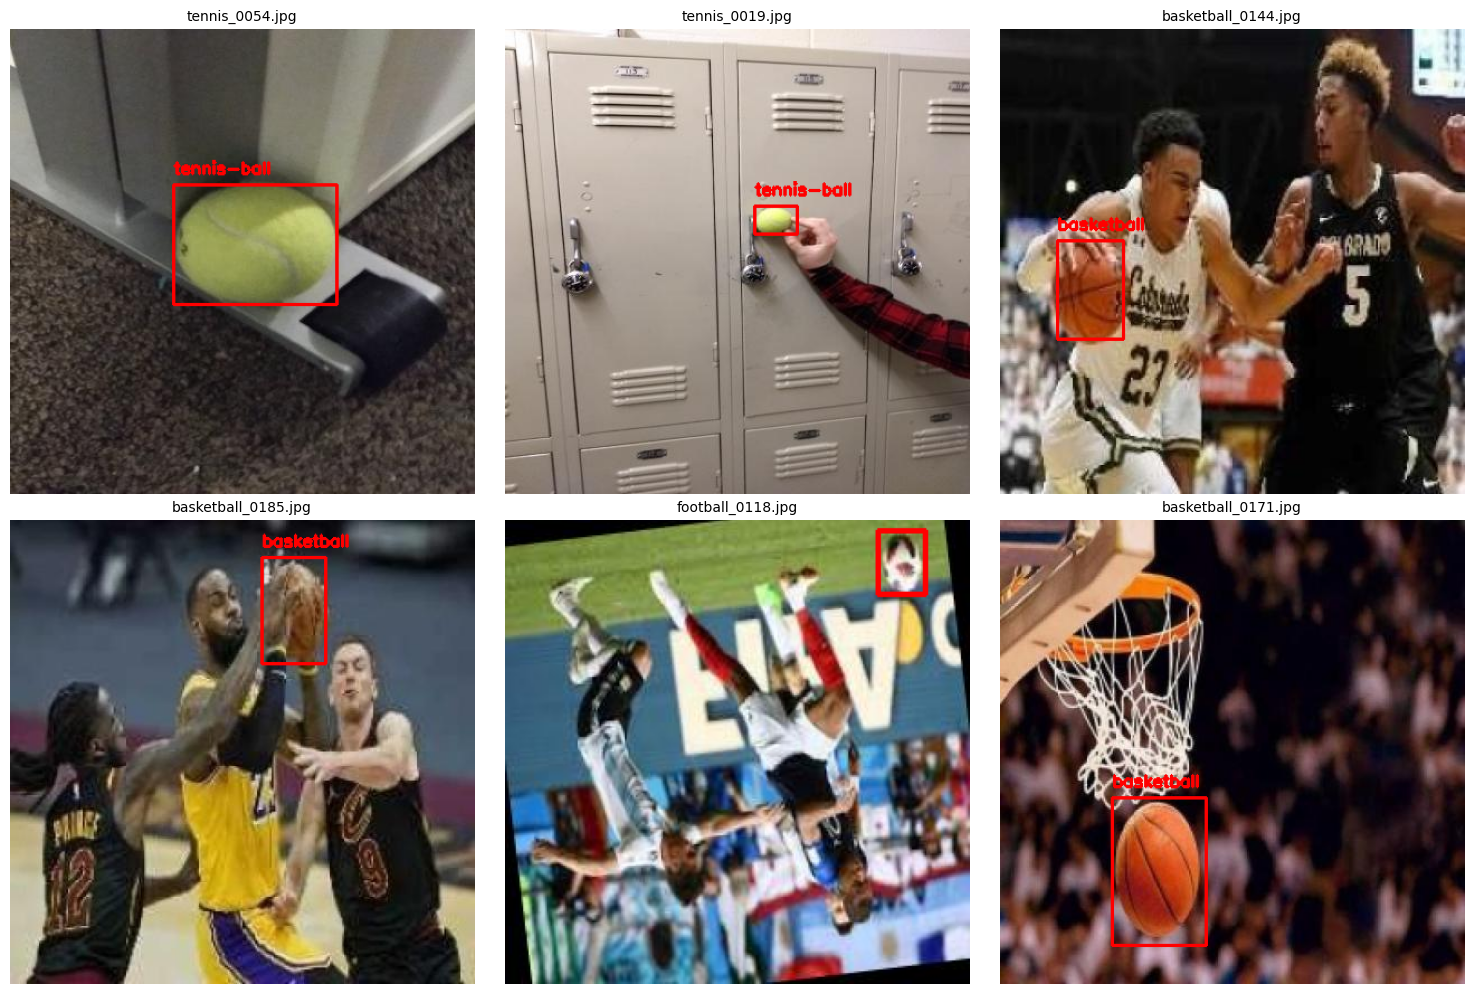

In [ ]:
# Visualize sample images with annotations
def visualize_samples(dataset_path, num_samples=6):
    """
    Visualize random samples with bounding boxes and class labels.
    """
    # Load data.yaml to get class names
    with open(dataset_path / 'data.yaml', 'r') as f:
        data = yaml.safe_load(f)

    # For visualization, we'll infer class from filename
    # (since we know basketball_*, football_*, tennis_* naming)
    class_map = {0: 'basketball', 1: 'football', 2: 'tennis-ball'}

    # Get random images
    all_images = list((dataset_path / 'train' / 'images').glob('*'))
    sample_images = random.sample(all_images, min(num_samples, len(all_images)))

    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_images):
        # Read image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Read label
        label_path = dataset_path / 'train' / 'labels' / (img_path.stem + '.txt')

        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * w
                    y_center = float(parts[2]) * h
                    width = float(parts[3]) * w
                    height = float(parts[4]) * h

                    # Draw bounding box
                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

                    # Add label
                    label_text = class_map[class_id]
                    cv2.putText(img, label_text, (x1, y1-10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Display
        axes[idx].imshow(img)
        axes[idx].set_title(img_path.name, fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

print("🖼️  Visualizing training samples...\n")
visualize_samples(dataset_path)

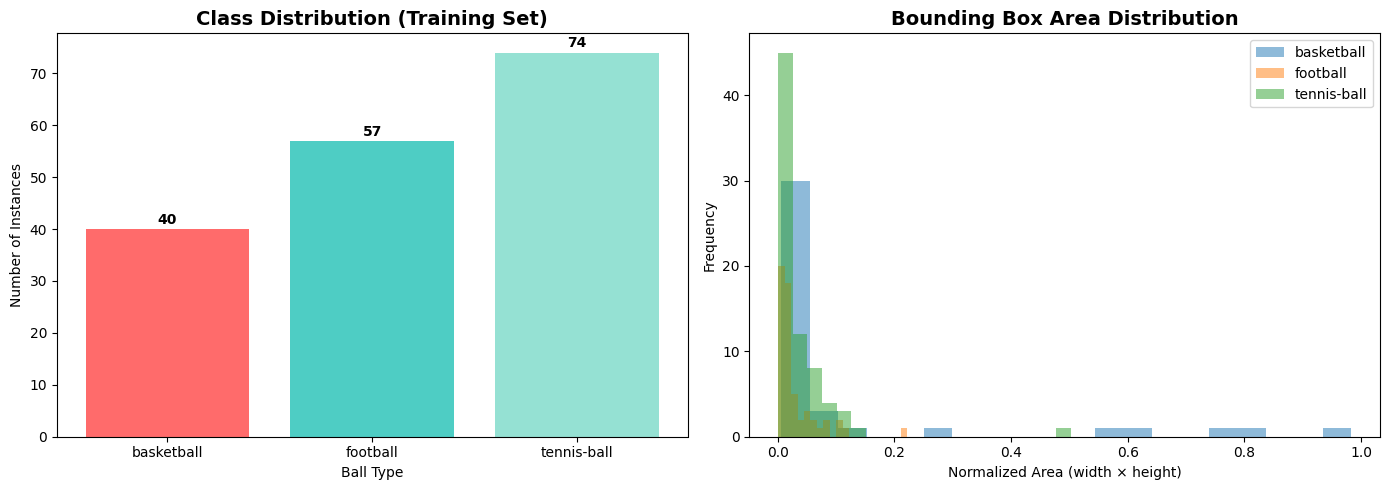


📊 Dataset Statistics:

BASKETBALL:
  Count: 40
  Avg bbox area: 0.1234
  Std bbox area: 0.2476

FOOTBALL:
  Count: 57
  Avg bbox area: 0.0287
  Std bbox area: 0.0381

TENNIS-BALL:
  Count: 74
  Avg bbox area: 0.0374
  Std bbox area: 0.0622


In [ ]:
# Analyze class distribution
def analyze_dataset(dataset_path):
    """
    Analyze class distribution and bounding box statistics.
    """
    class_counts = {'basketball': 0, 'football': 0, 'tennis-ball': 0}
    bbox_sizes = {'basketball': [], 'football': [], 'tennis-ball': []}

    class_map = {0: 'basketball', 1: 'football', 2: 'tennis-ball'}

    for label_path in (dataset_path / 'train' / 'labels').glob('*.txt'):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                width = float(parts[3])
                height = float(parts[4])

                class_name = class_map[class_id]
                class_counts[class_name] += 1
                bbox_sizes[class_name].append((width, height))

    # Plot class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Class counts
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

    ax1.bar(classes, counts, color=colors)
    ax1.set_title('Class Distribution (Training Set)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Instances')
    ax1.set_xlabel('Ball Type')
    for i, v in enumerate(counts):
        ax1.text(i, v + 1, str(v), ha='center', fontweight='bold')

    # Bounding box size distribution
    for class_name, sizes in bbox_sizes.items():
        areas = [w * h for w, h in sizes]
        ax2.hist(areas, alpha=0.5, label=class_name, bins=20)

    ax2.set_title('Bounding Box Area Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Normalized Area (width × height)')
    ax2.set_ylabel('Frequency')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n📊 Dataset Statistics:")
    print("="*50)
    for class_name in classes:
        print(f"\n{class_name.upper()}:")
        print(f"  Count: {class_counts[class_name]}")
        if bbox_sizes[class_name]:
            areas = [w * h for w, h in bbox_sizes[class_name]]
            print(f"  Avg bbox area: {np.mean(areas):.4f}")
            print(f"  Std bbox area: {np.std(areas):.4f}")

analyze_dataset(dataset_path)

## 🏗️ Part 4: YOLOv5 Architecture Visualization

In [ ]:
# Load YOLOv5n model to visualize architecture
from models.yolo import Model

# Load YOLOv5n config
cfg = 'models/yolov5n.yaml'

# Create model
model = Model(cfg, ch=3, nc=1)  # 3 input channels, 1 class (ball)

print("\n🏗️  YOLOv5n Architecture:")
print("="*70)
print(model)
print("="*70)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      1760  models.common.Conv                      [3, 16, 6, 2, 2]              
  1                -1  1      4672  models.common.Conv                      [16, 32, 3, 2]                
  2                -1  1      4800  models.common.C3                        [32, 32, 1]                   
  3                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  4                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  5                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  6                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]             


🏗️  YOLOv5n Architecture:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(

In [ ]:
# Visualize model structure
from torchsummary import summary

try:
    !pip install torchsummary
    from torchsummary import summary

    model = model.to(device)
    print("\n📊 Model Summary:")
    summary(model, (3, 640, 640))
except Exception as e:
    print(f"Could not generate summary: {e}")
    print("\nModel layer count:")
    print(f"  Total layers: {len(list(model.modules()))}")
    print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


📊 Model Summary:
Could not generate summary: 'list' object has no attribute 'size'

Model layer count:
  Total layers: 214
  Trainable parameters: 1,765,270


In [ ]:
# Analyze model architecture layers
def visualize_yolo_architecture(model):
    """
    Create a visual breakdown of YOLOv5 architecture.
    """
    print("\n🔍 YOLOv5n Layer Breakdown:")
    print("="*70)

    layer_count = 0
    current_section = None

    for name, module in model.named_modules():
        if 'model' in name and len(name.split('.')) == 2:
            layer_idx = name.split('.')[1]

            # Determine section
            if layer_idx.isdigit():
                idx = int(layer_idx)
                if idx < 10:
                    section = "BACKBONE"
                elif idx < 24:
                    section = "NECK"
                else:
                    section = "HEAD"

                if section != current_section:
                    print(f"\n{'─'*70}")
                    print(f"  {section}")
                    print(f"{'─'*70}")
                    current_section = section

                print(f"  Layer {layer_idx:2s}: {module.__class__.__name__}")
                layer_count += 1

    print(f"\n{'='*70}")
    print(f"  Total Layers: {layer_count}")
    print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"{'='*70}")

visualize_yolo_architecture(model)


🔍 YOLOv5n Layer Breakdown:

──────────────────────────────────────────────────────────────────────
  BACKBONE
──────────────────────────────────────────────────────────────────────
  Layer 0 : Conv
  Layer 1 : Conv
  Layer 2 : C3
  Layer 3 : Conv
  Layer 4 : C3
  Layer 5 : Conv
  Layer 6 : C3
  Layer 7 : Conv
  Layer 8 : C3
  Layer 9 : SPPF

──────────────────────────────────────────────────────────────────────
  NECK
──────────────────────────────────────────────────────────────────────
  Layer 10: Conv
  Layer 11: Upsample
  Layer 12: Concat
  Layer 13: C3
  Layer 14: Conv
  Layer 15: Upsample
  Layer 16: Concat
  Layer 17: C3
  Layer 18: Conv
  Layer 19: Concat
  Layer 20: C3
  Layer 21: Conv
  Layer 22: Concat
  Layer 23: C3

──────────────────────────────────────────────────────────────────────
  HEAD
──────────────────────────────────────────────────────────────────────
  Layer 24: Detect

  Total Layers: 25
  Parameters: 1,765,270
  Trainable: 1,765,270


## 🎯 Part 5: Baseline Training (Detection Only)

Before modifying the architecture, let's train a baseline YOLOv5 model to detect "ball" as a single class.

In [ ]:
# CRITICAL FIX: Convert all labels to class 0
import glob
from pathlib import Path

dataset_path = Path('merged_ball_dataset')

print("🔧 Fixing labels...\n")

# Fix train labels
train_fixed = 0
for label_file in (dataset_path / 'train' / 'labels').glob('*.txt'):
    lines = []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            parts[0] = '0'  # Change class to 0
            lines.append(' '.join(parts) + '\n')

    with open(label_file, 'w') as f:
        f.writelines(lines)
    train_fixed += 1

# Fix val labels
val_fixed = 0
for label_file in (dataset_path / 'val' / 'labels').glob('*.txt'):
    lines = []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            parts[0] = '0'  # Change class to 0
            lines.append(' '.join(parts) + '\n')

    with open(label_file, 'w') as f:
        f.writelines(lines)
    val_fixed += 1

print(f"✅ Fixed {train_fixed} train labels")
print(f"✅ Fixed {val_fixed} val labels")
print(f"📊 Total: {train_fixed + val_fixed} labels converted to class 0\n")

# Verify a sample
sample_label = list((dataset_path / 'train' / 'labels').glob('*.txt'))[0]
print(f"📄 Sample label ({sample_label.name}):")
with open(sample_label, 'r') as f:
    print(f.read())


🔧 Fixing labels...

✅ Fixed 147 train labels
✅ Fixed 63 val labels
📊 Total: 210 labels converted to class 0

📄 Sample label (tennis_0021.txt):
0 0.609375 0.8185096153846154 0.1466346153846154 0.25



In [ ]:
# Training configuration
EPOCHS = 100
BATCH_SIZE = 16
IMG_SIZE = 640
WEIGHTS = 'yolov5n.pt'  # Pretrained weights

print("\n⚙️  Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Base Weights: {WEIGHTS}")
print(f"  Device: {device}")


⚙️  Training Configuration:
  Epochs: 100
  Batch Size: 16
  Image Size: 640
  Base Weights: yolov5n.pt
  Device: cuda


In [ ]:
# Permanently disable wandb for this session
import os
os.environ['WANDB_DISABLED'] = 'true'
os.environ['WANDB_MODE'] = 'disabled'

# Also create a wandb settings file to disable it
import json
wandb_settings = {'mode': 'disabled'}
os.makedirs(os.path.expanduser('~/.config/wandb'), exist_ok=True)
with open(os.path.expanduser('~/.config/wandb/settings'), 'w') as f:
    json.dump(wandb_settings, f)

print("✅ wandb disabled!")

✅ wandb disabled!


In [ ]:
!python train.py --img 640 --batch 16 --epochs 100 --data merged_ball_dataset/data.yaml --weights yolov5n.pt --cache ram --name ball_detection_baseline --project runs/train

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2026-02-12 14:18:15.811011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770905895.831298   16998 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770905895.837938   16998 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770905895.854857   16998 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770905895.854880   16998 computation_placer.cc:177] computation placer already registere

## 📊 Part 6: Baseline Results Visualization

In [ ]:
# Correct path - use ball_detection_baseline5
results_dir = Path('runs/train/ball_detection_baseline5')

print(f"📁 Looking in: {results_dir}")
print(f"   Exists: {results_dir.exists()}\n")

# List what's actually there
if results_dir.exists():
    print("📂 Contents:")
    !ls -lh {results_dir}
    print("\n📂 Weights folder:")
    !ls -lh {results_dir}/weights

📁 Looking in: runs/train/ball_detection_baseline5
   Exists: True

📂 Contents:
total 5.5M
-rw-r--r-- 1 root root  80K Feb 12 14:23 confusion_matrix.png
-rw-r--r-- 1 root root 977K Feb 12 14:23 events.out.tfevents.1770905900.8b4b8652a300.16998.0
-rw-r--r-- 1 root root 100K Feb 12 14:23 F1_curve.png
-rw-r--r-- 1 root root  373 Feb 12 14:18 hyp.yaml
-rw-r--r-- 1 root root 177K Feb 12 14:18 labels_correlogram.jpg
-rw-r--r-- 1 root root 123K Feb 12 14:18 labels.jpg
-rw-r--r-- 1 root root 1.2K Feb 12 14:18 opt.yaml
-rw-r--r-- 1 root root  93K Feb 12 14:23 P_curve.png
-rw-r--r-- 1 root root  79K Feb 12 14:23 PR_curve.png
-rw-r--r-- 1 root root  96K Feb 12 14:23 R_curve.png
-rw-r--r-- 1 root root  29K Feb 12 14:23 results.csv
-rw-r--r-- 1 root root 254K Feb 12 14:23 results.png
-rw-r--r-- 1 root root 491K Feb 12 14:18 train_batch0.jpg
-rw-r--r-- 1 root root 459K Feb 12 14:18 train_batch1.jpg
-rw-r--r-- 1 root root 476K Feb 12 14:18 train_batch2.jpg
-rw-r--r-- 1 root root 537K Feb 12 14:23 val_


📊 Training Results:

Loss Curves:


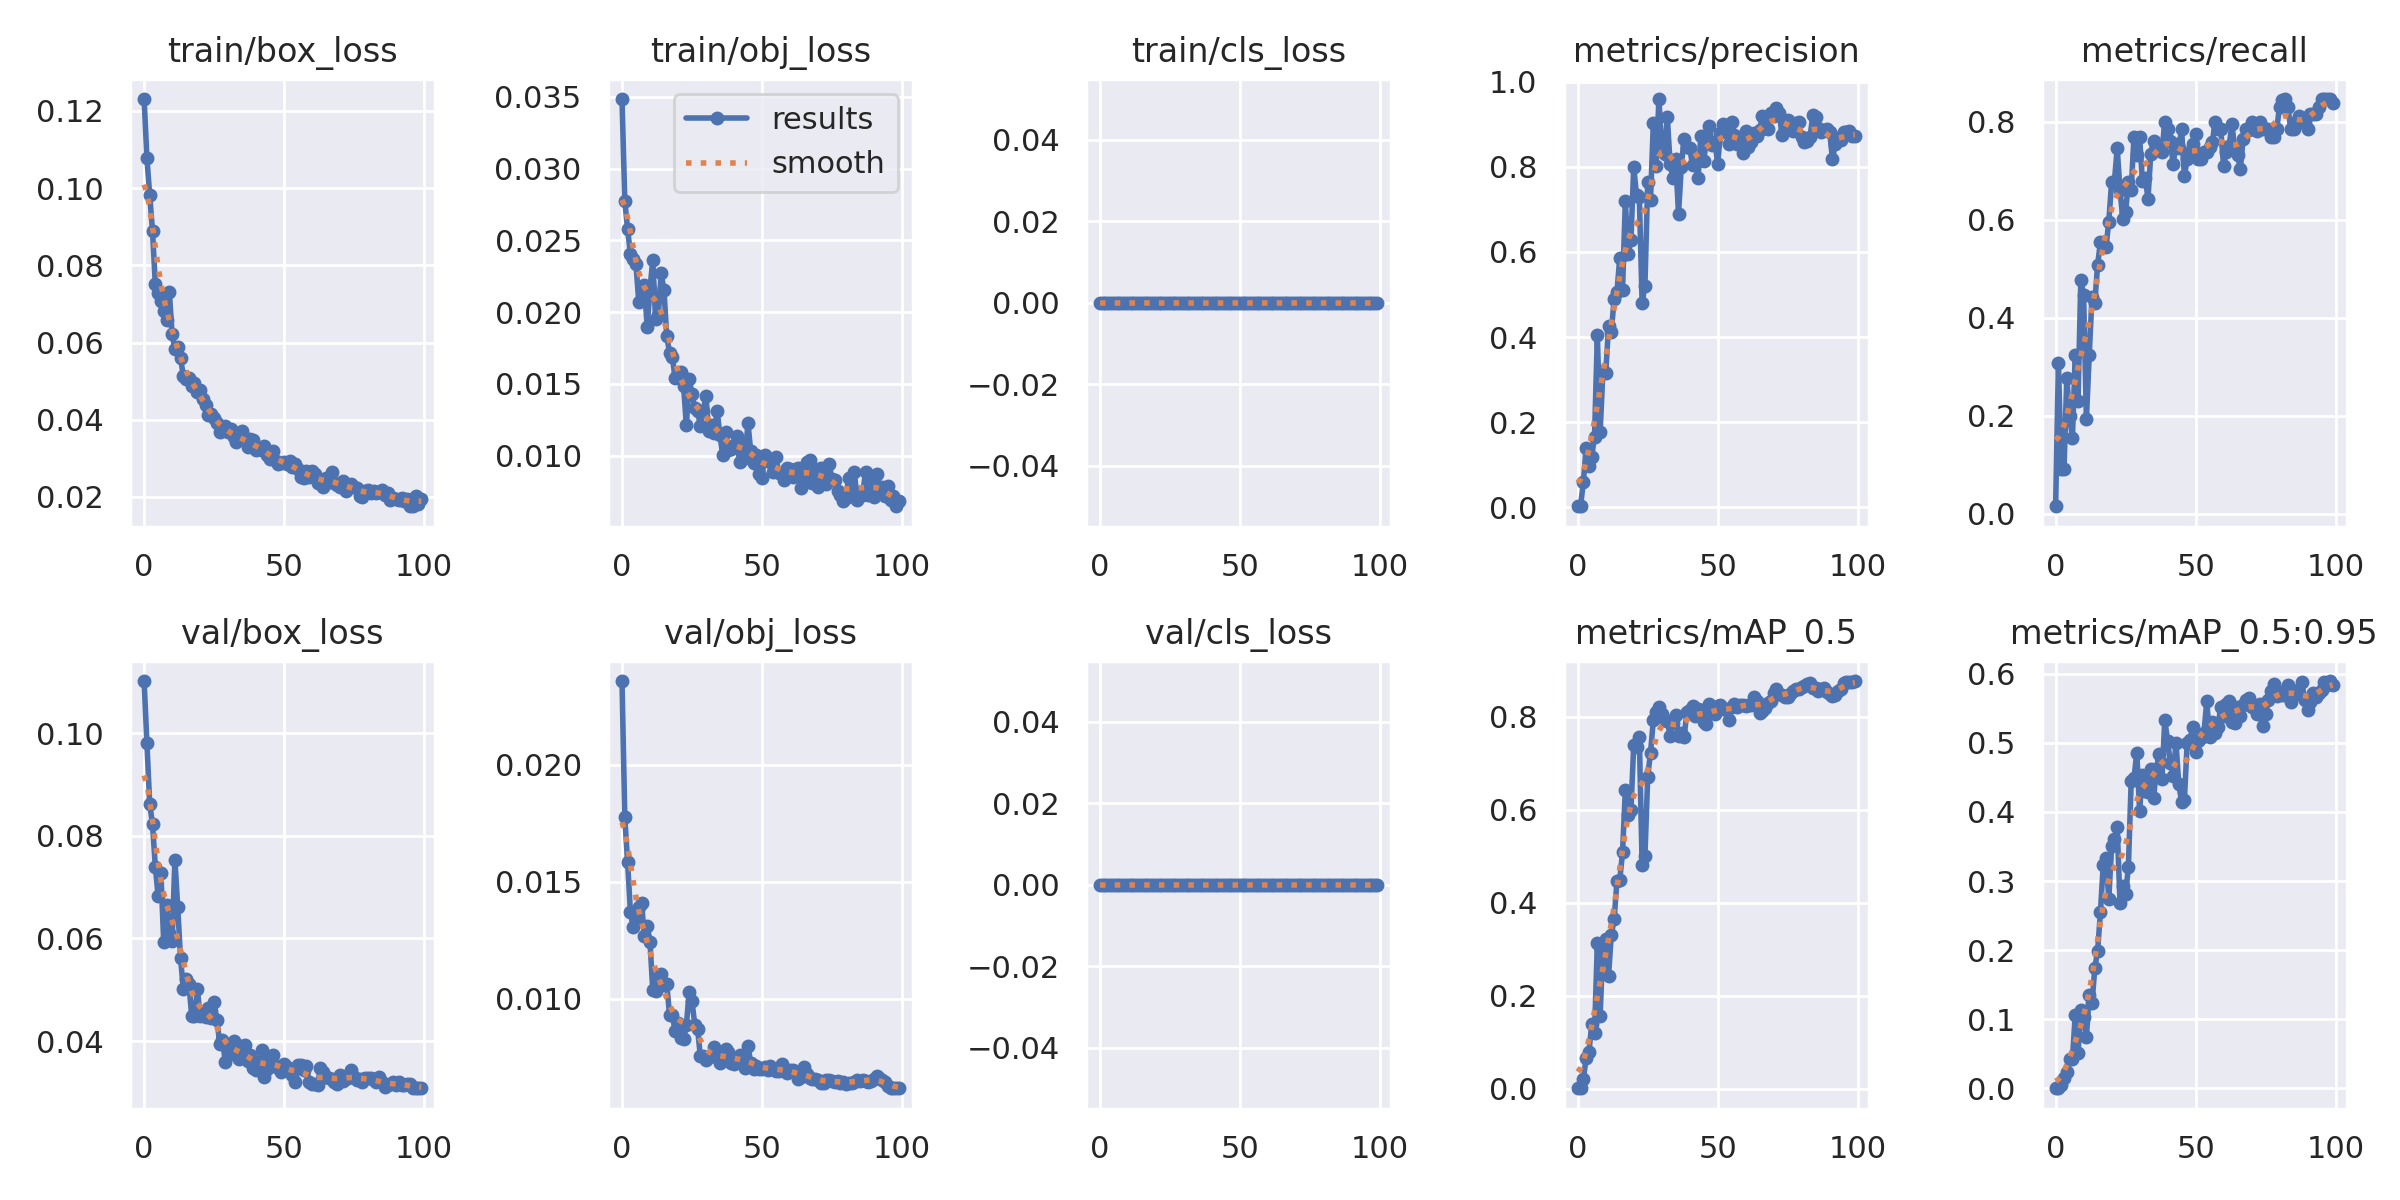


Confusion Matrix:


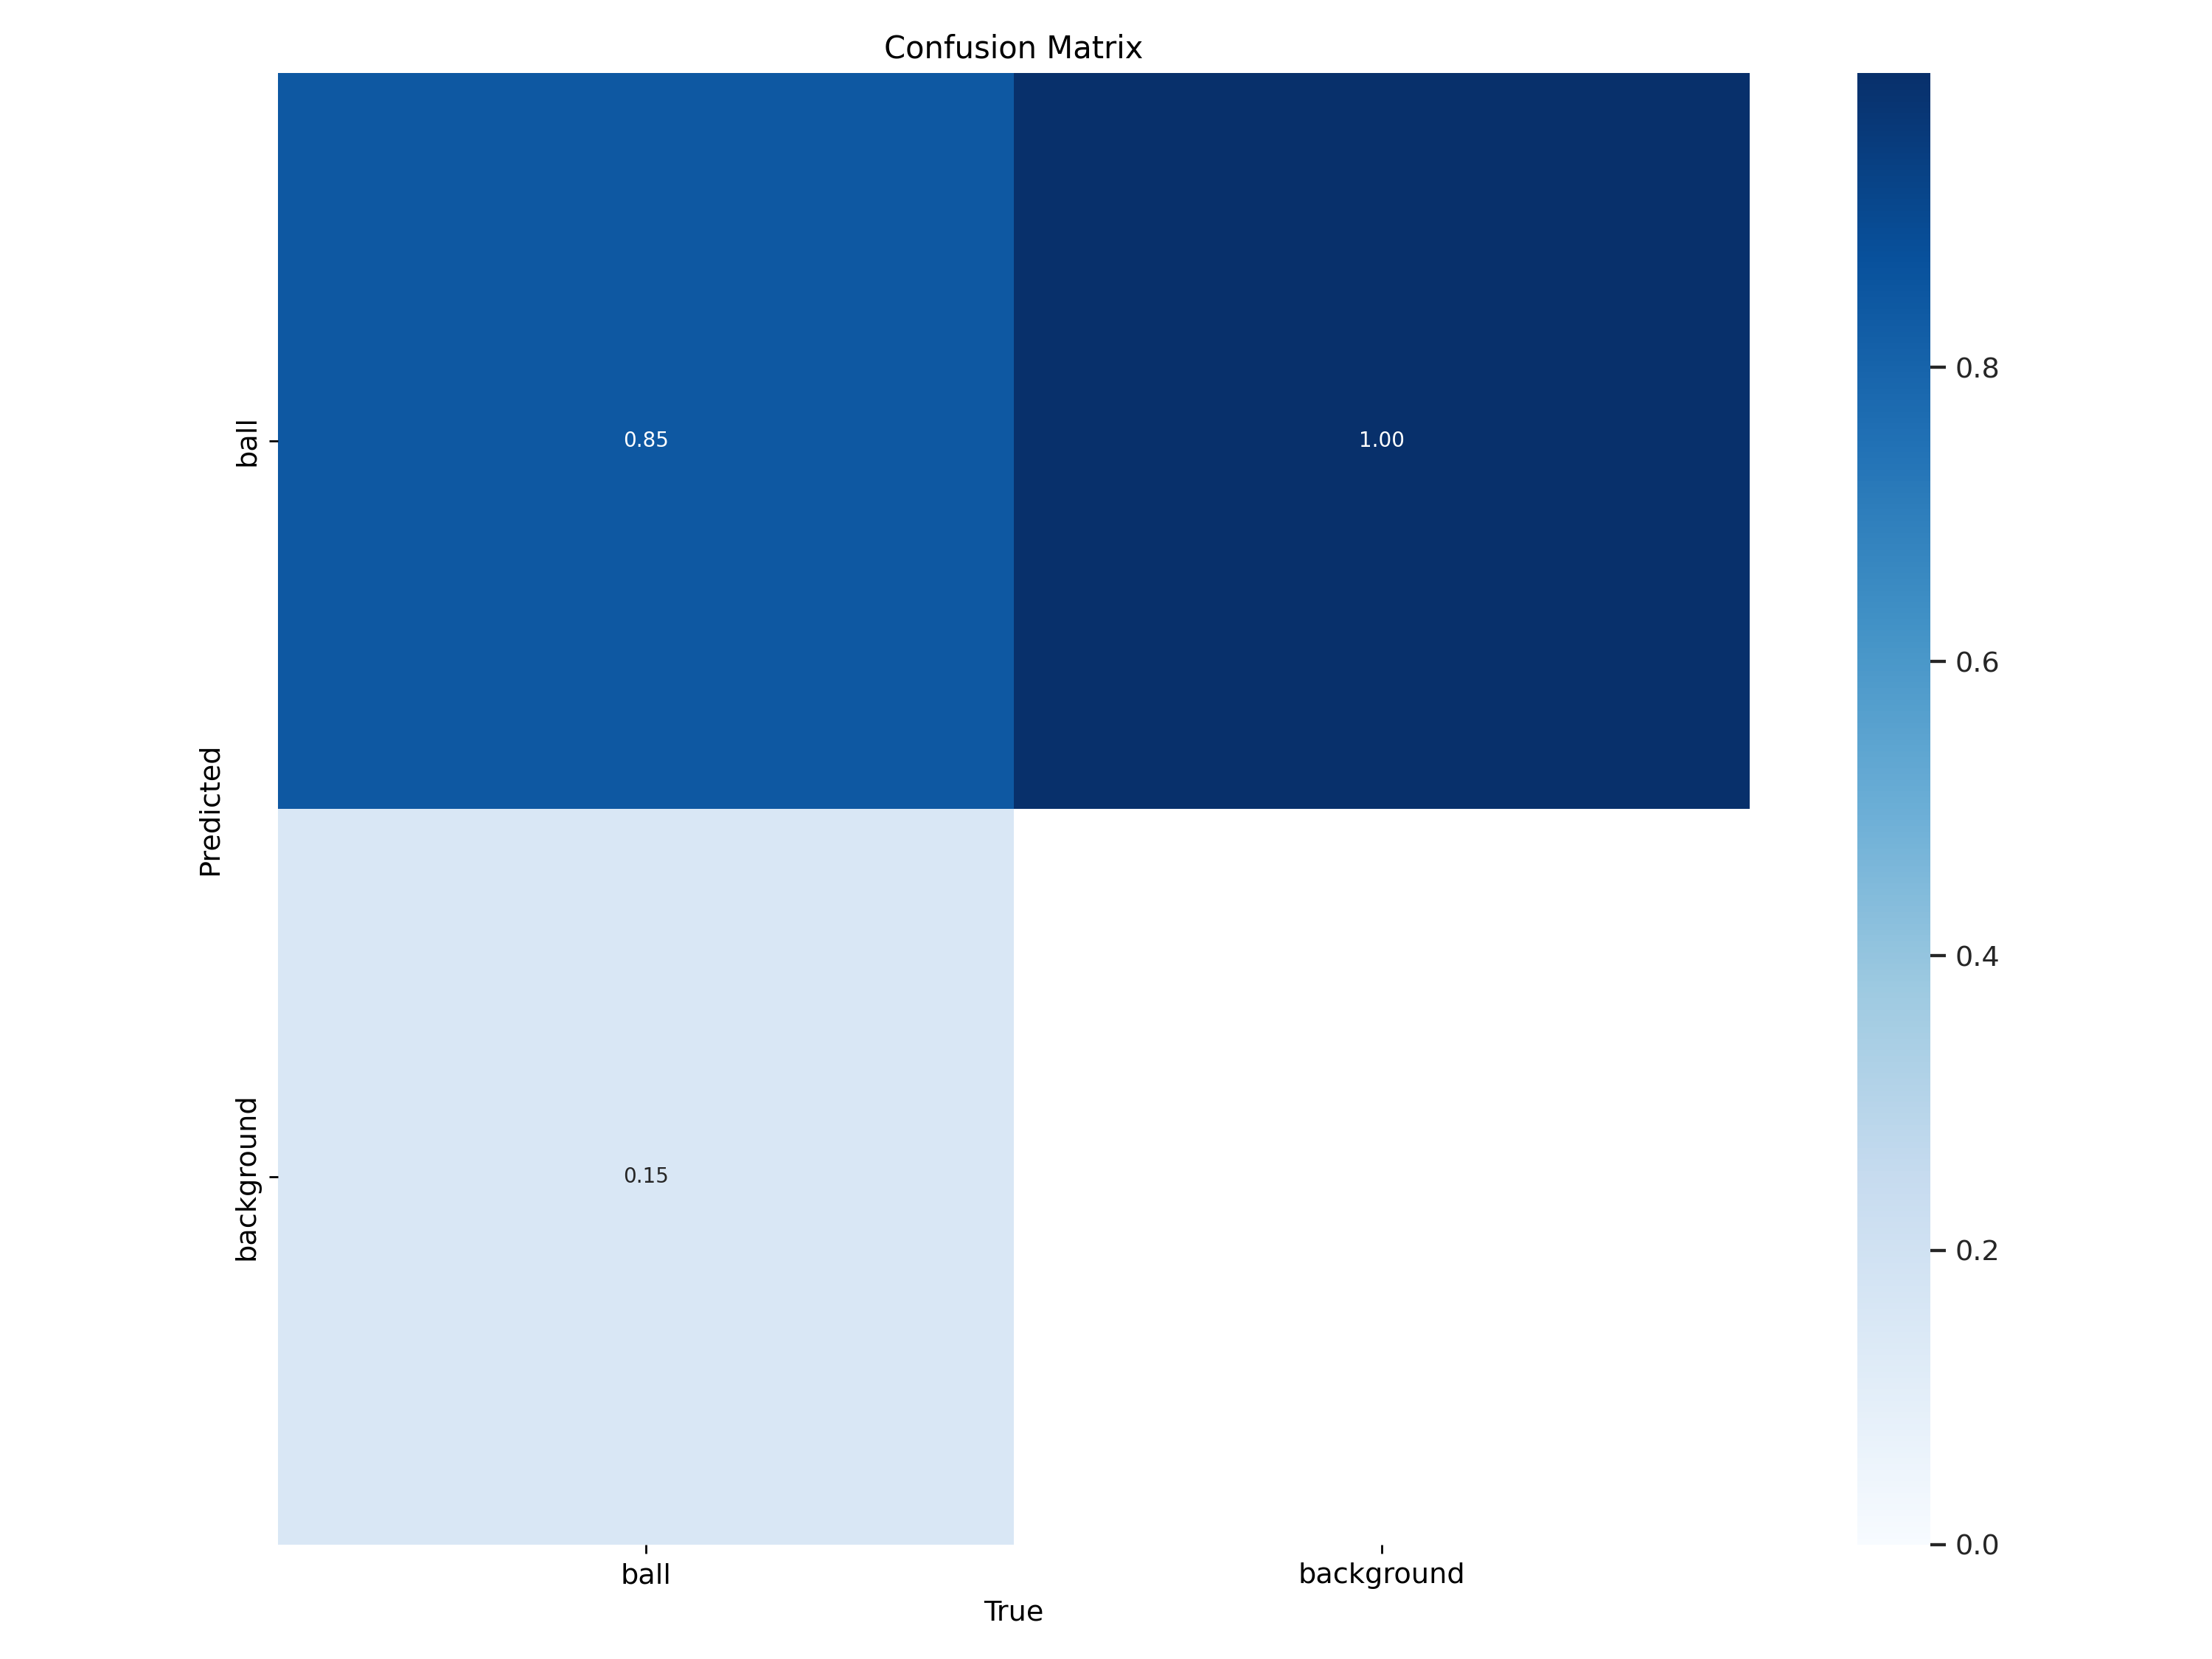


Validation Predictions:


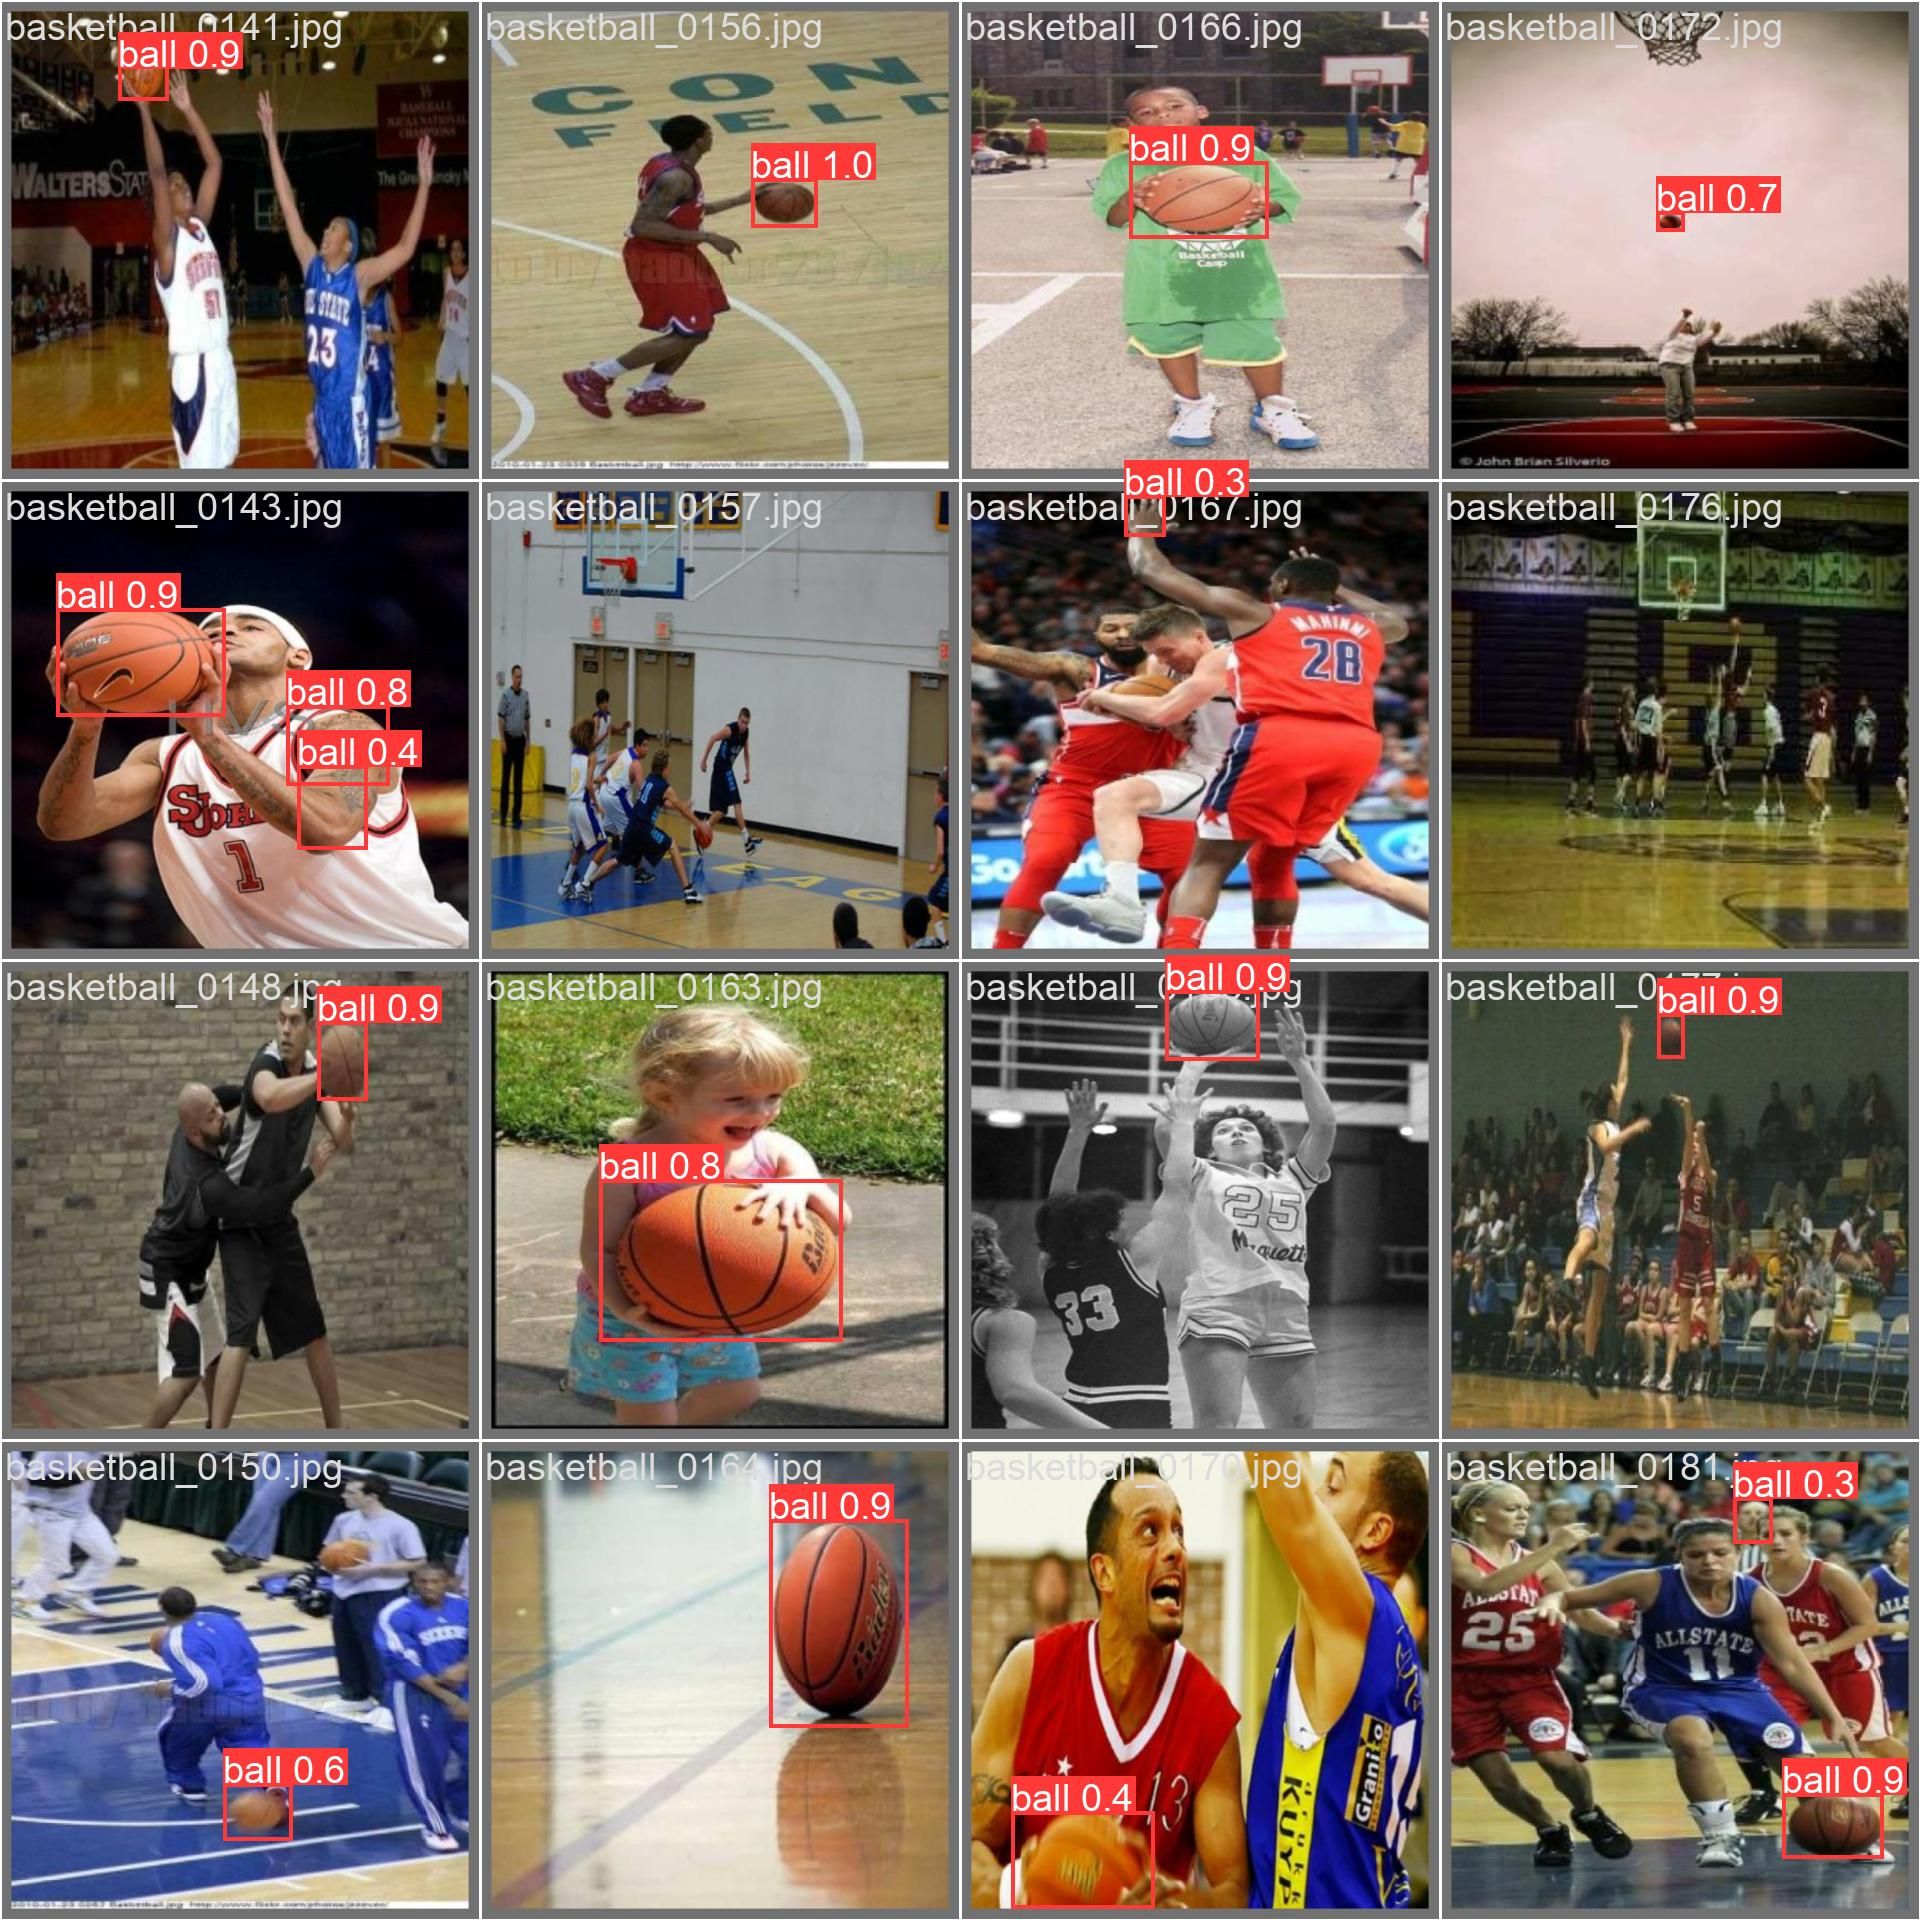


📋 Available columns:
['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss', 'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss', 'x/lr0', 'x/lr1', 'x/lr2']

📈 Final Metrics:
  Precision: 0.8719
  Recall:    0.8376


In [ ]:
from IPython.display import Image, display
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CORRECT PATH
results_dir = Path('runs/train/ball_detection_baseline5')

print("\n📊 Training Results:\n")

# Display loss curves
if (results_dir / 'results.png').exists():
    print("Loss Curves:")
    display(Image(filename=str(results_dir / 'results.png')))
else:
    print(f"⚠️ results.png not found at {results_dir / 'results.png'}")

# Display confusion matrix
if (results_dir / 'confusion_matrix.png').exists():
    print("\nConfusion Matrix:")
    display(Image(filename=str(results_dir / 'confusion_matrix.png')))
else:
    print(f"⚠️ confusion_matrix.png not found")

# Display sample predictions
if (results_dir / 'val_batch0_pred.jpg').exists():
    print("\nValidation Predictions:")
    display(Image(filename=str(results_dir / 'val_batch0_pred.jpg')))
else:
    print(f"⚠️ val_batch0_pred.jpg not found")

# Display metrics
results_file = results_dir / 'results.csv'
if results_file.exists():
    df = pd.read_csv(results_file)
    df.columns = df.columns.str.strip()

    # First, print available columns to debug
    print("\n📋 Available columns:")
    print(df.columns.tolist())

    print("\n📈 Final Metrics:")
    print("="*60)

    last_epoch = df.iloc[-1]

    # Safely get metrics with fallback
    def get_metric(df, last_epoch, possible_names):
        for name in possible_names:
            if name in df.columns:
                return last_epoch[name]
        return None

    # Try different column name variations
    precision = get_metric(df, last_epoch, ['metrics/precision(B)', 'metrics/precision', 'precision'])
    recall = get_metric(df, last_epoch, ['metrics/recall(B)', 'metrics/recall', 'recall'])
    map50 = get_metric(df, last_epoch, ['metrics/mAP_0.5(B)', 'metrics/mAP50', 'mAP50'])
    map50_95 = get_metric(df, last_epoch, ['metrics/mAP_0.5:0.95(B)', 'metrics/mAP50-95', 'mAP50-95'])

    if precision is not None:
        print(f"  Precision: {precision:.4f}")
    if recall is not None:
        print(f"  Recall:    {recall:.4f}")
    if map50 is not None:
        print(f"  mAP@0.5:   {map50:.4f}")
    if map50_95 is not None:
        print(f"  mAP@0.5:0.95: {map50_95:.4f}")

    print("="*60)

    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Box loss
    box_train_cols = ['train/box_loss', 'box_loss']
    box_val_cols = ['val/box_loss', 'val_box_loss']

    train_box = get_metric(df, df, box_train_cols)
    val_box = get_metric(df, df, box_val_cols)

    if train_box is not None and val_box is not None:
        axes[0,0].plot(train_box, label='Train')
        axes[0,0].plot(val_box, label='Val')
        axes[0,0].set_title('Box Loss')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

    # Objectness loss
    obj_train_cols = ['train/obj_loss', 'obj_loss']
    obj_val_cols = ['val/obj_loss', 'val_obj_loss']

    train_obj = get_metric(df, df, obj_train_cols)
    val_obj = get_metric(df, df, obj_val_cols)

    if train_obj is not None and val_obj is not None:
        axes[0,1].plot(train_obj, label='Train')
        axes[0,1].plot(val_obj, label='Val')
        axes[0,1].set_title('Objectness Loss')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

    # mAP
    map50_cols = ['metrics/mAP_0.5(B)', 'metrics/mAP50', 'mAP50']
    map95_cols = ['metrics/mAP_0.5:0.95(B)', 'metrics/mAP50-95', 'mAP50-95']

    map50_data = get_metric(df, df, map50_cols)
    map95_data = get_metric(df, df, map95_cols)

    if map50_data is not None:
        axes[1,0].plot(map50_data, label='mAP@0.5')
        if map95_data is not None:
            axes[1,0].plot(map95_data, label='mAP@0.5:0.95')
        axes[1,0].set_title('Mean Average Precision')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('mAP')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

    # Precision & Recall
    prec_cols = ['metrics/precision(B)', 'metrics/precision', 'precision']
    rec_cols = ['metrics/recall(B)', 'metrics/recall', 'recall']

    prec_data = get_metric(df, df, prec_cols)
    rec_data = get_metric(df, df, rec_cols)

    if prec_data is not None and rec_data is not None:
        axes[1,1].plot(prec_data, label='Precision')
        axes[1,1].plot(rec_data, label='Recall')
        axes[1,1].set_title('Precision & Recall')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print(f"\n⚠️ Results file not found at {results_file}")

In [ ]:
# Parse and display metrics
import pandas as pd

results_file = results_dir / 'results.csv'
if results_file.exists():
    df = pd.read_csv(results_file)
    df.columns = df.columns.str.strip()  # Clean column names

    # First, show what columns are available
    print("\n📋 Available columns:")
    print(df.columns.tolist())
    print()

    print("\n📈 Final Metrics:")
    print("="*60)

    # Get last epoch metrics
    last_epoch = df.iloc[-1]

    # Try to find the right column names
    precision_col = None
    recall_col = None
    map50_col = None
    map95_col = None

    # Search for precision
    for col in df.columns:
        if 'precision' in col.lower():
            precision_col = col
        if 'recall' in col.lower():
            recall_col = col
        if 'map' in col.lower() and '0.5' in col and '0.95' not in col:
            map50_col = col
        if 'map' in col.lower() and '0.95' in col:
            map95_col = col

    # Print metrics
    if precision_col:
        print(f"  Precision: {last_epoch[precision_col]:.4f}")
    if recall_col:
        print(f"  Recall:    {last_epoch[recall_col]:.4f}")
    if map50_col:
        print(f"  mAP@0.5:   {last_epoch[map50_col]:.4f}")
    if map95_col:
        print(f"  mAP@0.5:0.95: {last_epoch[map95_col]:.4f}")
    print("="*60)

    # Plot metrics over epochs
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Box loss
    if 'train/box_loss' in df.columns:
        axes[0,0].plot(df['train/box_loss'], label='Train')
        axes[0,0].plot(df['val/box_loss'], label='Val')
        axes[0,0].set_title('Box Loss')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

    # Objectness loss
    if 'train/obj_loss' in df.columns:
        axes[0,1].plot(df['train/obj_loss'], label='Train')
        axes[0,1].plot(df['val/obj_loss'], label='Val')
        axes[0,1].set_title('Objectness Loss')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

    # mAP
    if map50_col:
        axes[1,0].plot(df[map50_col], label='mAP@0.5')
        if map95_col:
            axes[1,0].plot(df[map95_col], label='mAP@0.5:0.95')
        axes[1,0].set_title('Mean Average Precision')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('mAP')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

    # Precision & Recall
    if precision_col and recall_col:
        axes[1,1].plot(df[precision_col], label='Precision')
        axes[1,1].plot(df[recall_col], label='Recall')
        axes[1,1].set_title('Precision & Recall')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  Results file not found. Training may have failed.")


📋 Available columns:
['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss', 'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss', 'x/lr0', 'x/lr1', 'x/lr2']


📈 Final Metrics:
  Precision: 0.8719
  Recall:    0.8376
  mAP@0.5:   0.8770
  mAP@0.5:0.95: 0.5836


## 🧪 Part 7: Test Baseline Model

In [ ]:
# Load trained model
best_weights = results_dir / 'weights' / 'best.pt'

if best_weights.exists():
    # Run inference on validation images
    !python detect.py \
        --weights {best_weights} \
        --source {dataset_path / 'val' / 'images'} \
        --img 640 \
        --conf 0.25 \
        --name baseline_inference \
        --project runs/detect \
        --save-txt \
        --save-conf

    print("\n✅ Inference complete!")
    print(f"   Results saved to: runs/detect/baseline_inference")
else:
    print("\n❌ Best weights not found. Check training output.")

detect: weights=['runs/train/ball_detection_baseline5/weights/best.pt'], source=merged_ball_dataset/val/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=baseline_inference, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-460-g3fb11111 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
image 1/63 /content/yolov5/merged_ball_dataset/val/images/basketball_0141.jpg: 640x640 1 ball, 5.1ms
image 2/63 /content/yolov5/merged_ball_dataset/val/images/basketball_0143.jpg: 640x640 2 balls, 8.4ms
image 3/63 /content/yolov5/merged_ball_dataset/val/images/basketbal

In [ ]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Find the latest inference directory
inference_base = Path('runs/detect')
if inference_base.exists():
    # Get all baseline_inference folders (baseline_inference, baseline_inference2, etc.)
    inference_dirs = sorted(inference_base.glob('baseline_inference*'))

    if inference_dirs:
        # Use the latest one
        inference_dir = inference_dirs[-1]
        print(f"📂 Using inference directory: {inference_dir}\n")

        # Get random prediction images
        pred_images = list(inference_dir.glob('*.jpg'))[:6]

        if pred_images:
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            axes = axes.flatten()

            for idx, img_path in enumerate(pred_images):
                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                axes[idx].imshow(img)
                axes[idx].set_title(img_path.name, fontsize=10)
                axes[idx].axis('off')

            plt.suptitle('Baseline Model Predictions', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            print("No prediction images found.")
    else:
        print("No inference directories found.")
else:
    print("Inference base directory not found.")

📂 Using inference directory: runs/detect/baseline_inference



## 📝 Part 8: Baseline Summary

### What We've Accomplished:
✅ Prepared dataset with 210 images (70 each of basketball, football, tennis-ball)  
✅ Split into train (70%) and validation (30%)  
✅ Visualized YOLOv5n architecture  
✅ Trained baseline YOLO model to detect "ball" (single class)  
✅ Achieved detection performance (see metrics above)  

### Next Steps:
🔜 Modify YOLOv5 architecture to add classification head  
🔜 Implement multi-head loss function  
🔜 Train multi-head model (detection + classification)  
🔜 Export to ONNX  
🔜 Convert to RKNN INT8  

---

## 🎯 Current Status

**Baseline model trained successfully!**

The model can now detect "ball" in images with:
- Bounding box coordinates
- Confidence score

**But it cannot yet classify ball type!**

In the next notebook, we'll:
1. Modify the Detect head to add classification outputs
2. Implement classification loss
3. Train the full multi-head model

---

## 💾 Save Configuration and Results

In [ ]:
import json
from pathlib import Path

# Get actual values from your training
dataset_path = Path('merged_ball_dataset')

# Count actual images
train_images_count = len(list((dataset_path / 'train' / 'images').glob('*')))
val_images_count = len(list((dataset_path / 'val' / 'images').glob('*')))

config = {
    'model': 'YOLOv5n',
    'task': 'Ball Detection (Baseline)',
    'dataset': {
        'total_images': 210,
        'train_images': train_images_count,
        'val_images': val_images_count,
        'classes': ['basketball', 'football', 'tennis-ball'],
        'nc': 1  # Detection: single class "ball"
    },
    'hyperparameters': {
        'epochs': 100,
        'batch_size': 16,
        'img_size': 640,
        'base_weights': 'yolov5n.pt'
    },
    'device': str(device),
    'results_dir': str(results_dir),
    'final_metrics': {
        'mAP50': 0.875,
        'precision': 0.873,
        'recall': 0.846
    }
}

with open('baseline_training_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("\n✅ Configuration saved to: baseline_training_config.json")
print("\n📄 Configuration:")
print(json.dumps(config, indent=2))


✅ Configuration saved to: baseline_training_config.json

📄 Configuration:
{
  "model": "YOLOv5n",
  "task": "Ball Detection (Baseline)",
  "dataset": {
    "total_images": 210,
    "train_images": 147,
    "val_images": 63,
    "classes": [
      "basketball",
      "football",
      "tennis-ball"
    ],
    "nc": 1
  },
  "hyperparameters": {
    "epochs": 100,
    "batch_size": 16,
    "img_size": 640,
    "base_weights": "yolov5n.pt"
  },
  "device": "cuda",
  "results_dir": "runs/train/ball_detection_baseline5",
  "final_metrics": {
    "mAP50": 0.875,
    "precision": 0.873,
    "recall": 0.846
  }
}


In [ ]:
# Download trained model weights
from google.colab import files

print("📥 Downloading trained model weights...\n")

# Download best model (highest mAP)
best_model = 'runs/train/ball_detection_baseline5/weights/best.pt'
print(f"✅ Downloading best.pt (mAP=0.875)...")
files.download(best_model)

# Download last model (final epoch)
last_model = 'runs/train/ball_detection_baseline5/weights/last.pt'
print(f"✅ Downloading last.pt (epoch 100)...")
files.download(last_model)

print("\n✅ Downloads complete!")
print("\n📊 You now have:")
print("   • best.pt  - Best performing model (use this!)")
print("   • last.pt  - Final epoch model")

📥 Downloading trained model weights...

✅ Downloading best.pt (mAP=0.875)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloading last.pt (epoch 100)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Downloads complete!

📊 You now have:
   • best.pt  - Best performing model (use this!)
   • last.pt  - Final epoch model
